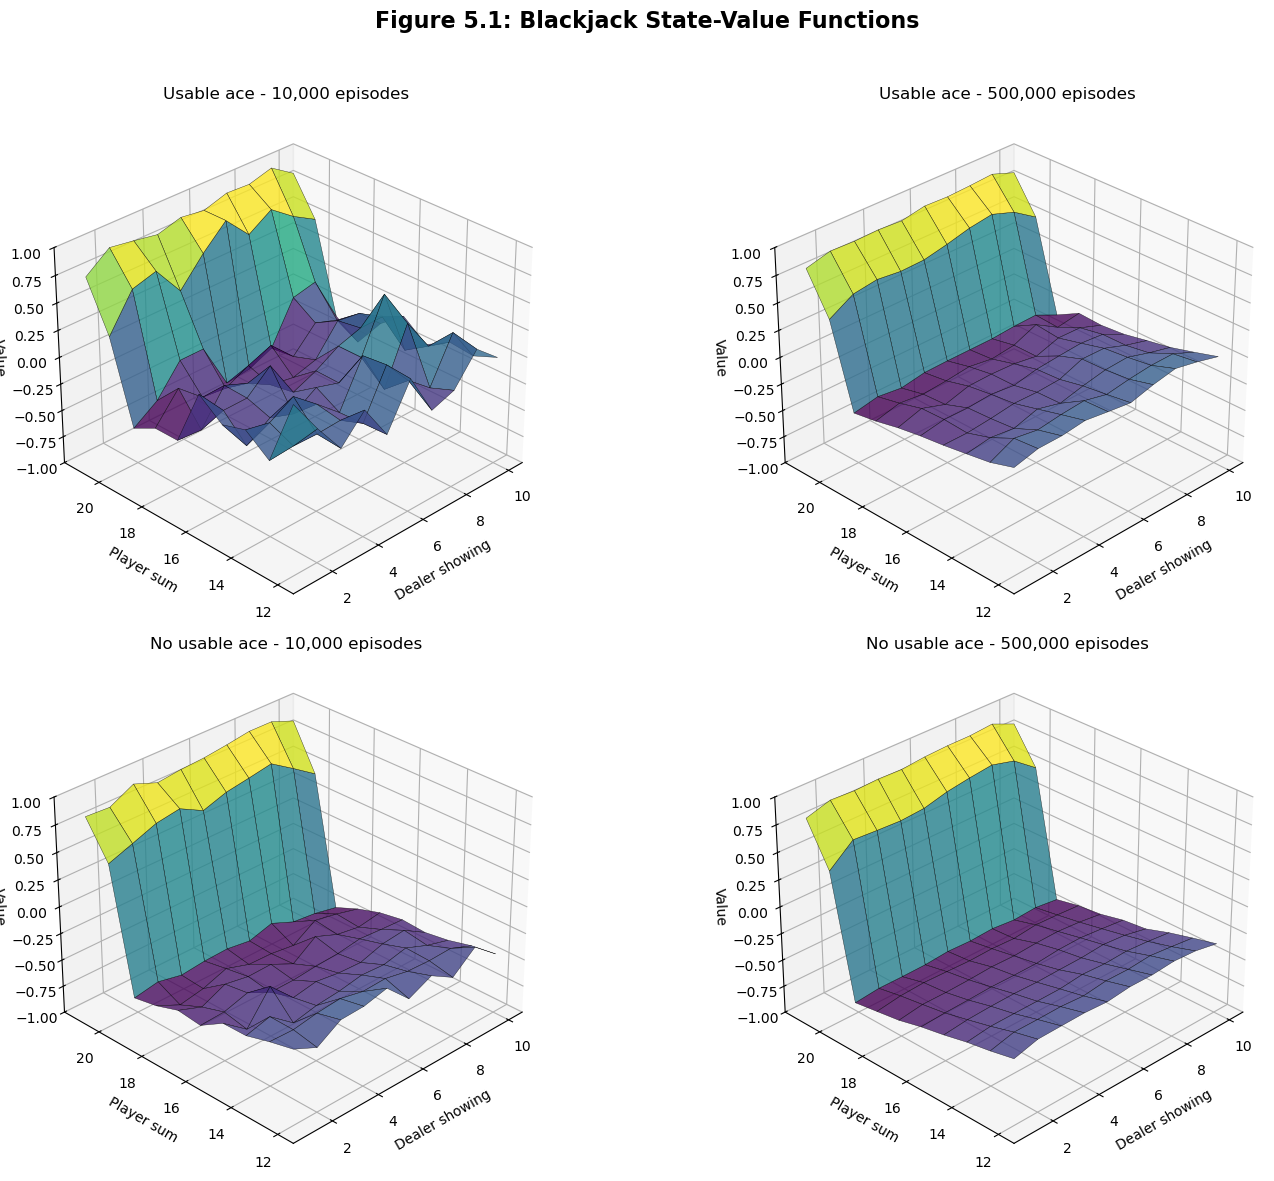

In [7]:
#Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Fgure 5.1
# Monte Carlo On policy
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

class BlackjackEnvironment:
    """
    Blackjack Environment Implementation
    
    From Sutton & Barto Section 5.1, Example 5.1:
    - The object of blackjack is to obtain cards whose sum is as great as 
      possible without exceeding 21
    - All face cards count as 10, and an ace can count either as 1 or as 11
    - Each player competes independently against the dealer
    - The game begins with two cards dealt to both dealer and player
    - One of the dealer's cards is face up (showing card) and one is face down
    
    State Space (200 states total):
    - Player's current sum (12-21): 10 possible values
    - Dealer's showing card (Ace-10): 10 possible values  
    - Whether player holds a usable ace (True/False): 2 possible values
    - Total: 10 × 10 × 2 = 200 states
    
    Note: Player sums below 12 are not included because the player should 
    always hit with sum < 12 (no decision to be made)
    
    Reward Structure:
    - +1 for winning
    - -1 for losing
    - 0 for draw
    - All intermediate rewards are 0
    - Discount factor γ = 1 (no discounting) as stated in textbook
    
    Environment Assumptions (from textbook):
    - Cards are dealt from an infinite deck (with replacement)
    - No advantage to keeping track of cards already dealt
    """
    
    # Action constants for readability
    ACTION_STICK = 0
    ACTION_HIT = 1
    
    # Dealer threshold - dealer must stick at this sum or higher
    DEALER_STICK_THRESHOLD = 17
    
    # Blackjack winning total
    BLACKJACK_TARGET = 21
    
    # Reward constants
    REWARD_WIN = 1
    REWARD_LOSS = -1
    REWARD_DRAW = 0
    
    def __init__(self):
        """
        Initialize the blackjack environment
        
        For infinite deck assumption, we set up uniform probabilities
        for cards 1-10, where:
        - Card 1 represents Ace
        - Cards 2-9 represent their face value
        - Card 10 represents 10, J, Q, K (all valued at 10)
        """
        # Current game state
        self.player_hand = []
        self.dealer_hand = []
        
        # Random number generator for reproducibility if needed
        self.rng = np.random.default_rng()
    
    def draw_card(self):
        """
        Draw a card from infinite deck
        
        Returns:
            int: Card value (1-10, where 1 is Ace)
        
        Note from textbook: 
        - Cards are dealt with replacement (infinite deck assumption)
        - This simplifies the problem by making draws independent
        
        Implementation details:
        - We use discrete uniform distribution over [1, 10]
        - Card value 10 represents any 10-value card (10, J, Q, K)
        - This matches the textbook's simplified model
        """
        # Draw uniformly from 1 to 10 (inclusive)
        # In a real deck, 10s are more common, but textbook uses uniform
        card_value = self.rng.integers(low=1, high=11)
        return card_value
    
    def usable_ace(self, hand):
        """
        Determine if the hand has a usable ace
        
        From textbook Section 5.1:
        "If the player holds an ace that he could count as 11 without going bust,
        then the ace is said to be usable. In this case it is always counted as 11
        because counting it as 1 would make the sum 11 or less, in which case there
        is no decision to be made because, obviously, the player should always hit."
        
        Args:
            hand: List of card values
            
        Returns:
            bool: True if hand has usable ace, False otherwise
            
        Logic:
        - An ace is "usable" if it can be counted as 11 without busting
        - This means: (sum of all cards) + 10 <= 21
        - The +10 comes from counting one ace as 11 instead of 1
        """
        # Check if hand contains at least one ace (value 1)
        has_ace = 1 in hand
        
        if not has_ace:
            return False
        
        # Calculate sum with all aces counted as 1
        current_sum = sum(hand)
        
        # Check if we can count one ace as 11 (adding 10 to current sum)
        # without exceeding 21
        can_use_ace_as_eleven = (current_sum + 10) <= self.BLACKJACK_TARGET
        
        return can_use_ace_as_eleven
    
    def sum_hand(self, hand):
        """
        Calculate the sum of a hand, accounting for usable ace
        
        Args:
            hand: List of card values
            
        Returns:
            int: Sum of hand (with ace counted optimally)
            
        Implementation note:
        - Start by counting all aces as 1
        - If there's a usable ace, add 10 to count it as 11
        - This gives us the optimal sum without busting
        """
        # Sum all cards (aces counted as 1)
        total_sum = sum(hand)
        
        # If we have a usable ace, count it as 11 instead of 1
        # This adds 10 to the total
        if self.usable_ace(hand):
            total_sum += 10
        
        return total_sum
    
    def is_bust(self, hand):
        """
        Check if hand is bust (sum > 21)
        
        Args:
            hand: List of card values
            
        Returns:
            bool: True if bust, False otherwise
        """
        return self.sum_hand(hand) > self.BLACKJACK_TARGET
    
    def reset(self):
        """
        Start a new episode
        
        From textbook:
        "The game begins with two cards dealt to both dealer and player.
        One of the dealer's cards is face up and the other is face down."
        
        Returns:
            state: Tuple of (player_sum, dealer_showing, usable_ace)
            
        Implementation notes:
        - Deal initial cards to both player and dealer
        - If player gets natural (21), handle it according to rules
        - Return the initial observable state
        """
        # Deal two cards to player
        self.player_hand = [self.draw_card(), self.draw_card()]
        
        # Deal two cards to dealer
        # First card is "showing" (face up), second is "hole card" (face down)
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        
        # Extract dealer's showing card (first card by convention)
        dealer_showing_card = self.dealer_hand[0]
        
        # Calculate player's sum and check for usable ace
        player_total = self.sum_hand(self.player_hand)
        has_usable_ace = self.usable_ace(self.player_hand)
        
        # Create state tuple: (player sum, dealer showing, usable ace)
        initial_state = (player_total, dealer_showing_card, has_usable_ace)
        
        return initial_state
    
    def step(self, action):
        """
        Execute one step in the environment
        
        Args:
            action: 0 = stick, 1 = hit
            
        Returns:
            next_state: Next state after action (or None if terminal)
            reward: Reward received
            done: Whether episode is complete
            
        From textbook Section 5.1:
        "The player's actions are to hit or to stick."
        
        Implementation structure:
        - If player hits: draw card, check for bust, return new state
        - If player sticks: dealer plays, determine winner, return reward
        """
        # CASE 1: Player chooses to HIT
        if action == self.ACTION_HIT:
            # Draw a new card and add to player's hand
            new_card = self.draw_card()
            self.player_hand.append(new_card)
            
            # Check if player went bust
            if self.is_bust(self.player_hand):
                # Player loses immediately
                # Episode ends, no next state needed
                return None, self.REWARD_LOSS, True
            
            # Player didn't bust - game continues
            # Calculate new state
            player_total = self.sum_hand(self.player_hand)
            dealer_showing_card = self.dealer_hand[0]
            has_usable_ace = self.usable_ace(self.player_hand)
            
            next_state = (player_total, dealer_showing_card, has_usable_ace)
            
            # No reward yet (intermediate reward is 0)
            return next_state, 0, False
        
        # CASE 2: Player chooses to STICK
        elif action == self.ACTION_STICK:
            # Player's turn is over - now dealer plays
            dealer_final_sum, dealer_busted = self.dealer_policy()
            
            # Calculate player's final sum
            player_final_sum = self.sum_hand(self.player_hand)
            
            # Determine outcome and assign reward
            if dealer_busted:
                # Dealer went bust - player wins!
                reward = self.REWARD_WIN
            elif player_final_sum > dealer_final_sum:
                # Player has higher sum - player wins!
                reward = self.REWARD_WIN
            elif player_final_sum < dealer_final_sum:
                # Dealer has higher sum - player loses
                reward = self.REWARD_LOSS
            else:
                # Same sum - it's a draw
                reward = self.REWARD_DRAW
            
            # Episode is complete
            return None, reward, True
        
        else:
            raise ValueError(f"Invalid action: {action}. Must be 0 (stick) or 1 (hit)")
    
    def dealer_policy(self):
        """
        Dealer's fixed strategy
        
        From textbook Section 5.1:
        "The dealer hits or sticks according to a fixed strategy without choice:
        he sticks on any sum of 17 or greater, and hits otherwise."
        
        Returns:
            final_sum: Dealer's final hand sum
            is_bust: Whether dealer went bust
            
        Implementation:
        - Dealer keeps hitting until reaching threshold or busting
        - No choice involved - purely deterministic based on current sum
        """
        # Dealer plays out their hand
        while True:
            current_dealer_sum = self.sum_hand(self.dealer_hand)
            
            # Check if dealer should stick
            if current_dealer_sum >= self.DEALER_STICK_THRESHOLD:
                # Dealer sticks - return final sum and bust status
                dealer_busted = current_dealer_sum > self.BLACKJACK_TARGET
                return current_dealer_sum, dealer_busted
            
            # Dealer must hit (sum < 17)
            new_card = self.draw_card()
            self.dealer_hand.append(new_card)
            
            # Check if dealer busted after drawing
            if self.is_bust(self.dealer_hand):
                # Dealer went bust
                final_sum = self.sum_hand(self.dealer_hand)
                return final_sum, True
    
    def natural(self, hand):
        """
        Check if hand is a natural (Ace + 10-card = 21 with 2 cards)
        
        From textbook:
        "If the player has 21 immediately (an ace and a 10-card), it is called 
        a natural. He then wins unless the dealer also has a natural, in which 
        case the game is a draw."
        
        Args:
            hand: List of card values
            
        Returns:
            bool: True if natural, False otherwise
            
        Logic:
        - Must have exactly 2 cards
        - Must sum to exactly 21
        - Must contain an ace (value 1) and a 10-value card
        """
        # Check for exactly 2 cards
        if len(hand) != 2:
            return False
        
        # Check if sum equals 21
        # (use sum_hand to properly handle ace)
        if self.sum_hand(hand) != self.BLACKJACK_TARGET:
            return False
        
        # Check for ace and 10-card combination
        # A natural requires one ace (1) and one 10-value card (10)
        has_ace = 1 in hand
        has_ten = 10 in hand
        
        return has_ace and has_ten


def simple_policy(state):
    """
    The policy to evaluate (from Figure 5.1 caption)
    
    From textbook Section 5.1:
    "Consider the policy that sticks if the player's sum is 20 or 21, 
    and otherwise hits."
    
    This is a fixed, deterministic policy:
    - Stick (action 0) if player sum is 20 or 21
    - Hit (action 1) otherwise
    
    Args:
        state: Tuple of (player_sum, dealer_showing, usable_ace)
        
    Returns:
        action: 0 = stick, 1 = hit
    """
    # Unpack state tuple
    player_sum, dealer_showing, usable_ace = state
    
    # Policy decision based on player's sum
    if player_sum >= 20:
        # Stick on 20 or 21
        return BlackjackEnvironment.ACTION_STICK
    else:
        # Hit on anything less than 20
        return BlackjackEnvironment.ACTION_HIT


def first_visit_mc_prediction(policy, env, num_episodes, gamma=1.0):
    """
    First-visit Monte Carlo policy evaluation
    
    Algorithm from Sutton & Barto Section 5.1 (page 92):
    
    Input: a policy π to be evaluated
    Initialize:
        V(s) ∈ ℝ, arbitrarily, for all s ∈ S
        Returns(s) ← an empty list, for all s ∈ S
    Loop forever (for each episode):
        Generate an episode following π: S₀, A₀, R₁, S₁, A₁, R₂, ..., S_{T-1}, A_{T-1}, R_T
        G ← 0
        Loop for each step of episode, t = T-1, T-2, ..., 0:
            G ← γG + R_{t+1}
            Unless S_t appears in S₀, S₁, ..., S_{t-1}:
                Append G to Returns(S_t)
                V(S_t) ← average(Returns(S_t))
    
    Key concepts from textbook:
    - "First-visit MC method estimates v_π(s) as the average of the returns 
       following first visits to s"
    - "Each return is an independent, identically distributed estimate of v_π(s)"
    - "By the law of large numbers the sequence of averages converges to the 
       expected value"
    - "The standard deviation of error falls as 1/√n where n is the number of 
       returns averaged"
    
    Args:
        policy: Function mapping states to actions
        env: BlackjackEnvironment instance
        num_episodes: Number of episodes to run (10,000 or 500,000 for Figure 5.1)
        gamma: Discount factor (1.0 for blackjack as per textbook)
        
    Returns:
        V: Dictionary mapping states to estimated values
    """
    
    # Initialize value function arbitrarily (we use 0.0 for all states)
    # V maps state -> estimated value
    # Using defaultdict so unvisited states automatically have value 0.0
    V = defaultdict(float)
    
    # Returns(s) stores list of returns following first visits to state s
    # From textbook: We need to track all returns to compute the average
    # This is the key data structure for Monte Carlo learning
    # Each state maps to a list of all returns observed after first visits
    Returns = defaultdict(list)
    
    # Track progress for long runs
    
    # Loop for each episode
    for episode_num in range(num_episodes):
        
        # GENERATE AN EPISODE following policy π
        # Episode is sequence: S₀, A₀, R₁, S₁, A₁, R₂, ..., S_{T-1}, A_{T-1}, R_T
        # We store tuples of (state, action, reward) for each time step
        episode_history = []
        
        # Reset environment to get initial state S₀
        current_state = env.reset()
        
        # Generate complete episode until terminal state
        episode_complete = False
        
        while not episode_complete:
            # Get action from policy for current state
            action = policy(current_state)
            
            # Take action in environment
            next_state, reward, episode_complete = env.step(action)
            
            # Store this transition
            # Note: We store (state, action, reward) where reward is R_{t+1}
            # This matches the textbook notation: taking action A_t in state S_t
            # gives us reward R_{t+1}
            episode_history.append((current_state, action, reward))
            
            # Move to next state (if episode continues)
            if not episode_complete:
                current_state = next_state
        
        # CALCULATE RETURNS AND UPDATE VALUE FUNCTION
        # Work backwards from end of episode
        # This is the key insight: we know the final outcome, so we work backwards
        # assigning returns to each state visited
        
        # G is the return (cumulative discounted reward from time t onward)
        # Initialize to 0 and build up as we go backwards
        cumulative_return = 0.0
        
        # Track which states we've already seen in this backward pass
        # This is crucial for implementing "first-visit" MC
        # We only want to update a state the FIRST time we see it (going backwards)
        states_seen_in_reverse = set()
        
        # Loop backwards through episode (t = T-1, T-2, ..., 0)
        # Going backwards means we process the END of the episode first
        for step_index in range(len(episode_history) - 1, -1, -1):
            
            # Extract state, action, and reward from this time step
            # episode_history[step_index] = (S_t, A_t, R_{t+1})
            state_at_step, action_at_step, reward_received = episode_history[step_index]
            
            # Calculate return: G ← γ * G + R_{t+1}
            # From textbook: For blackjack, γ = 1, so G ← G + R_{t+1}
            # This accumulates rewards going backwards through the episode
            cumulative_return = gamma * cumulative_return + reward_received
            
            # FIRST-VISIT CHECK
            # "Unless S_t appears in S₀, S₁, ..., S_{t-1}"
            # This is the key difference between first-visit and every-visit MC
            # 
            # Going backwards: we only process a state if we haven't seen it yet
            # in our backward traversal. This ensures we only count the FIRST
            # visit to each state (chronologically first = last seen going backwards)
            if state_at_step not in states_seen_in_reverse:
                
                # Mark this state as seen
                states_seen_in_reverse.add(state_at_step)
                
                # Append return to Returns(S_t)
                # This builds up our sample of returns for this state
                Returns[state_at_step].append(cumulative_return)
                
                # Update value estimate: V(S_t) ← average(Returns(S_t))
                # From textbook: "The value estimate is the sample mean of returns"
                # As we collect more samples, this average converges to true value
                V[state_at_step] = np.mean(Returns[state_at_step])
    
    return V


def first_visit_mc_prediction_with_counts(policy, env, num_episodes, gamma=1.0):
    """
    First-visit Monte Carlo prediction with visit counts tracked
    
    This is an alternative implementation that tracks visit counts separately.
    This can be more memory efficient for large numbers of episodes since we
    don't store every single return - we just update a running average.
    
    Mathematically equivalent to the version above, but uses incremental updates:
    V(S) ← V(S) + (1/N(S)) * [G - V(S)]
    
    where N(S) is the number of times we've visited state S.
    
    Args:
        policy: Function mapping states to actions
        env: BlackjackEnvironment instance
        num_episodes: Number of episodes to run
        gamma: Discount factor
        
    Returns:
        V: Dictionary mapping states to estimated values
        visit_counts: Dictionary mapping states to number of visits
    """
    
    # Value function: state -> estimated value
    V = defaultdict(float)
    
    # Visit counts: state -> number of first visits
    # This tracks how many times we've updated each state's value
    visit_counts = defaultdict(int)
    
    
    for episode_num in range(num_episodes):
        
        # GENERATE EPISODE
        episode_history = []
        current_state = env.reset()
        episode_complete = False
        
        while not episode_complete:
            action = policy(current_state)
            next_state, reward, episode_complete = env.step(action)
            episode_history.append((current_state, action, reward))
            
            if not episode_complete:
                current_state = next_state
        
        # PROCESS EPISODE BACKWARDS
        cumulative_return = 0.0
        states_seen_in_reverse = set()
        
        for step_index in range(len(episode_history) - 1, -1, -1):
            state_at_step, action_at_step, reward_received = episode_history[step_index]
            
            # Accumulate return
            cumulative_return = gamma * cumulative_return + reward_received
            
            # First-visit check
            if state_at_step not in states_seen_in_reverse:
                states_seen_in_reverse.add(state_at_step)
                
                # Increment visit count
                visit_counts[state_at_step] += 1
                
                # Incremental update formula
                # This is mathematically equivalent to taking the mean of all returns
                # but only requires storing one value instead of a list
                # 
                # Formula: V_new = V_old + (1/N) * (G - V_old)
                # This is a "moving average" update
                n = visit_counts[state_at_step]
                current_value = V[state_at_step]
                V[state_at_step] = current_value + (1.0 / n) * (cumulative_return - current_value)
        
    
    return V, visit_counts


        
def state_value_to_arrays(V, usable_ace):
    """
    Convert state-value dictionary to 2D arrays for plotting
    
    The state space for plotting is:
    - X-axis: Dealer showing card (1-10, representing Ace through 10)
    - Y-axis: Player sum (12-21)
    - Z-axis: Value V(s)
    - Separate plots for usable ace vs. no usable ace
    
    Args:
        V: Dictionary mapping (player_sum, dealer_showing, usable_ace) -> value
        usable_ace: Boolean, which ace condition to extract
        
    Returns:
        values: 2D numpy array of shape (10, 10) for plotting
                rows = player sum (12-21)
                cols = dealer showing (1-10)
                
    Implementation notes:
    - We create a 10x10 grid where each cell represents a state
    - Row i corresponds to player sum (12 + i)
    - Column j corresponds to dealer showing card (1 + j)
    - We only extract states matching the specified usable_ace condition
    """
    
    # Define the ranges for our state space
    # Player sums: 12 through 21 (10 values)
    player_sum_range = range(12, 22)  # 12, 13, ..., 21
    
    # Dealer showing: 1 through 10 (10 values)
    # 1 = Ace, 2-9 = face value, 10 = 10/J/Q/K
    dealer_showing_range = range(1, 11)  # 1, 2, ..., 10
    
    # Initialize 10x10 array with zeros
    # Shape: (10 rows for player sums, 10 cols for dealer cards)
    value_grid = np.zeros((len(player_sum_range), len(dealer_showing_range)))
    
    # Populate the grid with values from V
    # We iterate through all possible state combinations
    for row_idx, player_sum in enumerate(player_sum_range):
        for col_idx, dealer_showing in enumerate(dealer_showing_range):
            
            # Construct the state tuple
            # State format: (player_sum, dealer_showing, usable_ace)
            state = (player_sum, dealer_showing, usable_ace)
            
            # Look up value in V dictionary
            # If state not visited, defaultdict returns 0.0 (neutral value)
            value_grid[row_idx, col_idx] = V[state]
    
    return value_grid


def plot_value_function(V, num_episodes, title_suffix=""):
    """
    Create 3D surface plots matching Figure 5.1 layout
    
    Figure 5.1 shows:
    - Left column: After 10,000 episodes
    - Right column: After 500,000 episodes
    - Top row: Usable ace
    - Bottom row: No usable ace
    
    Each subplot shows:
    - X-axis: Dealer showing (A, 2, 3, ..., 10)
    - Y-axis: Player sum (12, 13, ..., 21)
    - Z-axis: State value (approximately -1 to +1)
    
    The plots are wireframe/surface plots showing the value function as a 3D surface
    
    Args:
        V: Value function dictionary
        num_episodes: Number of episodes run (for title)
        title_suffix: Additional text for title
    """
    
    # Create figure with 2 subplots arranged vertically
    # figsize controls the overall size - adjust for readability
    fig = plt.figure(figsize=(10, 12))
    
    # Define the ranges for our axes
    player_sum_range = np.arange(12, 22)   # 12 through 21
    dealer_showing_range = np.arange(1, 11)  # 1 through 10
    
    # Create meshgrid for 3D plotting
    # X = dealer showing, Y = player sum
    # meshgrid creates coordinate matrices from coordinate vectors
    dealer_mesh, player_mesh = np.meshgrid(dealer_showing_range, player_sum_range)
    
    # Plot 1: Usable Ace (top subplot)
    ax1 = fig.add_subplot(2, 1, 1, projection='3d')
    
    # Convert value function to 2D array for usable ace case
    values_usable_ace = state_value_to_arrays(V, usable_ace=True)
    
    # Create 3D surface plot
    # Use plot_surface for filled surface (more like textbook figure)
    # Alternative: plot_wireframe for wireframe only
    surface1 = ax1.plot_surface(
        dealer_mesh, 
        player_mesh, 
        values_usable_ace,
        #cmap='viridis',      # Color map (can use 'coolwarm', 'RdYlGn', etc.)
        alpha=0.8,           # Transparency
        edgecolor='black',   # Edge color for grid lines
        linewidth=0.3,       # Thickness of grid lines
        antialiased=True     # Smooth rendering
    )
    
    # Set axis labels
    ax1.set_xlabel('Dealer showing', fontsize=10, labelpad=8)
    ax1.set_ylabel('Player sum', fontsize=10, labelpad=8)
    ax1.set_zlabel('Value', fontsize=10, labelpad=8)
    
    # Set axis limits to match textbook appearance
    ax1.set_xlim(1, 10)
    ax1.set_ylim(12, 21)
    ax1.set_zlim(-1, 1)  # Value range typically -1 to +1
    
    # Set title
    ax1.set_title('Usable ace', fontsize=12, pad=10)
    
    # Adjust viewing angle to match textbook figure
    # elev = elevation angle, azim = azimuth angle
    ax1.view_init(elev=30, azim=225)
    
    # Plot 2: No Usable Ace (bottom subplot)
    ax2 = fig.add_subplot(2, 1, 2, projection='3d')
    
    # Convert value function to 2D array for no usable ace case
    values_no_usable_ace = state_value_to_arrays(V, usable_ace=False)
    
    # Create 3D surface plot
    surface2 = ax2.plot_surface(
        dealer_mesh, 
        player_mesh, 
        values_no_usable_ace,
        cmap='viridis',
        alpha=0.8,
        edgecolor='black',
        linewidth=0.3,
        antialiased=True
    )
    
    # Set axis labels
    ax2.set_xlabel('Dealer showing', fontsize=10, labelpad=8)
    ax2.set_ylabel('Player sum', fontsize=10, labelpad=8)
    ax2.set_zlabel('Value', fontsize=10, labelpad=8)
    
    # Set axis limits
    ax2.set_xlim(1, 10)
    ax2.set_ylim(12, 21)
    ax2.set_zlim(-1, 1)
    
    # Set title
    ax2.set_title('No usable ace', fontsize=12, pad=10)
    
    # Adjust viewing angle
    ax2.view_init(elev=30, azim=225)
    
    # Add overall title
    fig.suptitle(
        f'After {num_episodes:,} episodes{title_suffix}',
        fontsize=14,
        fontweight='bold',
        y=0.98
    )
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Display the plot
    plt.show()


def plot_value_function_side_by_side(V_10k, V_500k):
    """
    Create side-by-side comparison plots matching Figure 5.1 exactly
    
    This creates a 2x2 grid:
    - Column 1: After 10,000 episodes
    - Column 2: After 500,000 episodes
    - Row 1: Usable ace
    - Row 2: No usable ace
    
    Args:
        V_10k: Value function after 10,000 episodes
        V_500k: Value function after 500,000 episodes
    """
    
    # Create figure with 2x2 subplot grid
    fig = plt.figure(figsize=(16, 12))
    
    # Define the ranges for our axes
    player_sum_range = np.arange(12, 22)
    dealer_showing_range = np.arange(1, 11)
    
    # Create meshgrid
    dealer_mesh, player_mesh = np.meshgrid(dealer_showing_range, player_sum_range)
    
    # Common viewing angle for all subplots
    elevation_angle = 30
    azimuth_angle = 225
    
    # ROW 1, COL 1: Usable ace, 10k episodes
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    values_1 = state_value_to_arrays(V_10k, usable_ace=True)
    ax1.plot_surface(dealer_mesh, player_mesh, values_1, 
                     cmap='viridis', alpha=0.8, edgecolor='black', linewidth=0.3)
    ax1.set_xlabel('Dealer showing')
    ax1.set_ylabel('Player sum')
    ax1.set_zlabel('Value')
    ax1.set_title('Usable ace - 10,000 episodes')
    ax1.set_zlim(-1, 1)
    ax1.view_init(elev=elevation_angle, azim=azimuth_angle)
    
    # ROW 1, COL 2: Usable ace, 500k episodes
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    values_2 = state_value_to_arrays(V_500k, usable_ace=True)
    ax2.plot_surface(dealer_mesh, player_mesh, values_2,
                     cmap='viridis', alpha=0.8, edgecolor='black', linewidth=0.3)
    ax2.set_xlabel('Dealer showing')
    ax2.set_ylabel('Player sum')
    ax2.set_zlabel('Value')
    ax2.set_title('Usable ace - 500,000 episodes')
    ax2.set_zlim(-1, 1)
    ax2.view_init(elev=elevation_angle, azim=azimuth_angle)
    
    # ROW 2, COL 1: No usable ace, 10k episodes
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    values_3 = state_value_to_arrays(V_10k, usable_ace=False)
    ax3.plot_surface(dealer_mesh, player_mesh, values_3,
                     cmap='viridis', alpha=0.8, edgecolor='black', linewidth=0.3)
    ax3.set_xlabel('Dealer showing')
    ax3.set_ylabel('Player sum')
    ax3.set_zlabel('Value')
    ax3.set_title('No usable ace - 10,000 episodes')
    ax3.set_zlim(-1, 1)
    ax3.view_init(elev=elevation_angle, azim=azimuth_angle)
    
    # ROW 2, COL 2: No usable ace, 500k episodes
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    values_4 = state_value_to_arrays(V_500k, usable_ace=False)
    ax4.plot_surface(dealer_mesh, player_mesh, values_4,
                     cmap='viridis', alpha=0.8, edgecolor='black', linewidth=0.3)
    ax4.set_xlabel('Dealer showing')
    ax4.set_ylabel('Player sum')
    ax4.set_zlabel('Value')
    ax4.set_title('No usable ace - 500,000 episodes')
    ax4.set_zlim(-1, 1)
    ax4.view_init(elev=elevation_angle, azim=azimuth_angle)
    
    # Overall title
    fig.suptitle('Figure 5.1: Blackjack State-Value Functions', 
                 fontsize=16, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Test the visualization functions
if __name__ == "__main__":
    # Create blackjack environment
	env = BlackjackEnvironment()
	
	# Run First-Visit MC Prediction for 10,000 episodes
	V_10k = first_visit_mc_prediction(simple_policy, env, num_episodes=10000)
	
	# Plot value function after 10,000 episodes
	#plot_value_function(V_10k, num_episodes=10000)
	
	# Run First-Visit MC Prediction for 500,000 episodes
	V_500k = first_visit_mc_prediction(simple_policy, env, num_episodes=500000)
	
	# Plot value function after 500,000 episodes
	#plot_value_function(V_500k, num_episodes=500000)
	
	# Plot side-by-side comparison matching Figure 5.1
	plot_value_function_side_by_side(V_10k, V_500k)